# Handling binary data columns

The CISS-VAE model can handle binary and categorical variables in addition to continuous ones. Categorical variables must be represented with binary dummy variables. 

When imputing binary data, we apply a sigmoid activation function at the end to convert to a probability. Because some datasets have both binary and continuous variables, you can input a binary variable mask (boolean vector) to tell the model which variables are binary so it acts accordingly. 

## Example dataset

The example dataset below has both binary and continuous variables in it:

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_rows = 100
prop_mask = 0.3

X = pd.DataFrame({
    "feat1": np.random.choice(np.arange(1, n_rows + 1), size=n_rows, replace=True),
    "feat2": np.random.choice(np.arange(1, 6), size=n_rows, replace=True),
    "feat3": np.random.choice(np.arange(1, 8), size=n_rows, replace=True),
    "feat4": np.random.choice(np.arange(1, 8), size=n_rows, replace=True),
    "feat5": np.random.choice(np.arange(1, 8), size=n_rows, replace=True),
    ## now add some binary features
    "bf1": np.random.binomial(1, 0.25, size=n_rows),
    "bf2": np.random.binomial(1, 0.5, size=n_rows),
    "bf3": np.random.binomial(1, 0.75, size=n_rows),
    "bf4": np.random.binomial(1, 0.33, size=n_rows),
    "bf5": np.random.binomial(1, 0.66, size=n_rows),
})

X_raw = X.copy()

for col in X.columns[1:]:  # skip feat1
    idx = np.where(~X[col].isna())[0]  # indices of non-NA entries
    n_mask = int(np.ceil(len(idx) * prop_mask))
    if n_mask > 0:
        mask_idx = np.random.choice(idx, size=n_mask, replace=False)
        X.loc[mask_idx, col] = np.nan

print(f"X matrix:\n{X}")


## choosing random clusters for now 
clusters = np.random.choice([1, 2, 3], size=n_rows, replace=True)



X matrix:
    feat1  feat2  feat3  feat4  feat5  bf1  bf2  bf3  bf4  bf5
0      52    2.0    6.0    4.0    2.0  NaN  NaN  NaN  NaN  0.0
1      93    1.0    7.0    NaN    2.0  NaN  1.0  1.0  1.0  1.0
2      15    4.0    NaN    4.0    2.0  0.0  0.0  1.0  0.0  NaN
3      72    4.0    3.0    NaN    1.0  NaN  1.0  NaN  1.0  NaN
4      61    NaN    1.0    NaN    1.0  0.0  NaN  NaN  NaN  0.0
..    ...    ...    ...    ...    ...  ...  ...  ...  ...  ...
95     85    NaN    NaN    6.0    2.0  0.0  0.0  1.0  NaN  1.0
96     80    1.0    NaN    7.0    2.0  0.0  NaN  1.0  NaN  1.0
97     82    2.0    4.0    NaN    1.0  0.0  NaN  1.0  NaN  NaN
98     53    4.0    3.0    7.0    7.0  NaN  0.0  0.0  0.0  1.0
99     24    4.0    1.0    3.0    NaN  0.0  1.0  1.0  1.0  0.0

[100 rows x 10 columns]


### Preparing Binary Vector

The binary vector `binary_feature_mask` is of length p for an n x p data matrix and is `True` for binary columns and `False` for continuous columns. 

In [2]:
binary_vector = [False, False, False, False, False, True, True, True, True, True]



## Using `run_cissvae()` with binary matrix

Pass the binary vector to the `run_cissvae()` function using the `binary_feature_mask` argument. Note: even if columns are ignored via `columns_ignore`, those columns must be included in the `binary_feature_mask`. 

In [3]:
import ciss_vae

from ciss_vae.training.run_cissvae import run_cissvae
from ciss_vae.utils.helpers import plot_vae_architecture
print(ciss_vae.__file__)

imputed_data, vae, ds, history = run_cissvae(data = X,
## Dataset params
    columns_ignore = X.columns[0], ## columns to ignore when selecting validation dataset (and clustering if you do not provide clusters). For example, demographic columns with no missingness.
    clusters = clusters,
    print_dataset = False,
    binary_feature_mask = binary_vector,
## VAE model params
    hidden_dims = [150, 120, 60], ## Dimensions of hidden layers, in order. One number per layer. 
    latent_dim = 15, ## Dimensions of latent embedding
    layer_order_enc = ["unshared", "unshared", "unshared"], ## order of shared vs unshared layers for encode (can use u or s instead of unshared, shared)
    layer_order_dec=["shared", "shared",  "shared"],  ## order of shared vs unshared layers for decode
    latent_shared=False, 
    output_shared=False, 
    batch_size = 4000, ## batch size for data loader
    return_model = True, ## if true, outputs imputed dataset and model, otherwise just outputs imputed dataset. Set to true to return model for `plot_vae_architecture`

## Initial Training params
    epochs = 5, ## default 

## Other params
    return_history = True, ## if true, will return training MSE history as pandas dataframe
    return_dataset=True,
    debug = False
)

print(f"The successfully imputed dataset:\n{imputed_data.head}\n\n")

/home/nfs/vaithid1/CISS-VAE/CISS-VAE/src/ciss_vae/__init__.py
The successfully imputed dataset:
<bound method NDFrame.head of     feat1     feat2     feat3     feat4     feat5       bf1       bf2  \
0    52.0  2.000000  6.000000  4.000000  2.000000  0.460673  0.518950   
1    93.0  1.000000  7.000000  4.314068  2.000000  0.353987  1.000000   
2    15.0  4.000000  3.029701  4.000000  2.000000  0.000000  0.000000   
3    72.0  4.000000  3.000000  4.831545  1.000000  0.408324  1.000000   
4    61.0  3.175432  1.000000  4.731658  1.000000  0.000000  0.409775   
..    ...       ...       ...       ...       ...       ...       ...   
95   85.0  2.661184  3.993314  6.000000  2.000000  0.000000  0.000000   
96   80.0  1.000000  3.964527  7.000000  2.000000  0.000000  0.492954   
97   82.0  2.000000  4.000000  4.816206  1.000000  0.000000  0.498996   
98   53.0  4.000000  3.000000  7.000000  7.000000  0.257940  0.000000   
99   24.0  4.000000  1.000000  3.000000  3.702055  0.000000  1.000000  

In [4]:
print(f"History \n{history}")

History 
    epoch  train_loss     val_mse        lr  train_recon  train_kl  \
0       0    5.761711  352.931213  0.010000          NaN       NaN   
1       1    5.572648  512.886108  0.009990          NaN       NaN   
2       2    5.451443  441.929413  0.009980          NaN       NaN   
3       3    5.332067  321.070618  0.009970          NaN       NaN   
4       4    5.141943  351.920227  0.009960          NaN       NaN   
5       4         NaN  348.323181  0.009950          NaN       NaN   
6       9         NaN  336.765686  0.009900          NaN       NaN   
7       0    5.987548         NaN  0.009950          NaN       NaN   
8       1    6.699108         NaN  0.009940          NaN       NaN   
9       2    6.421870         NaN  0.009930          NaN       NaN   
10      3    6.146056         NaN  0.009920          NaN       NaN   
11      4    6.243982         NaN  0.009910          NaN       NaN   
12     14         NaN  208.144775  0.009851          NaN       NaN   
13      0  

As always, the vae architecture can be printed. 

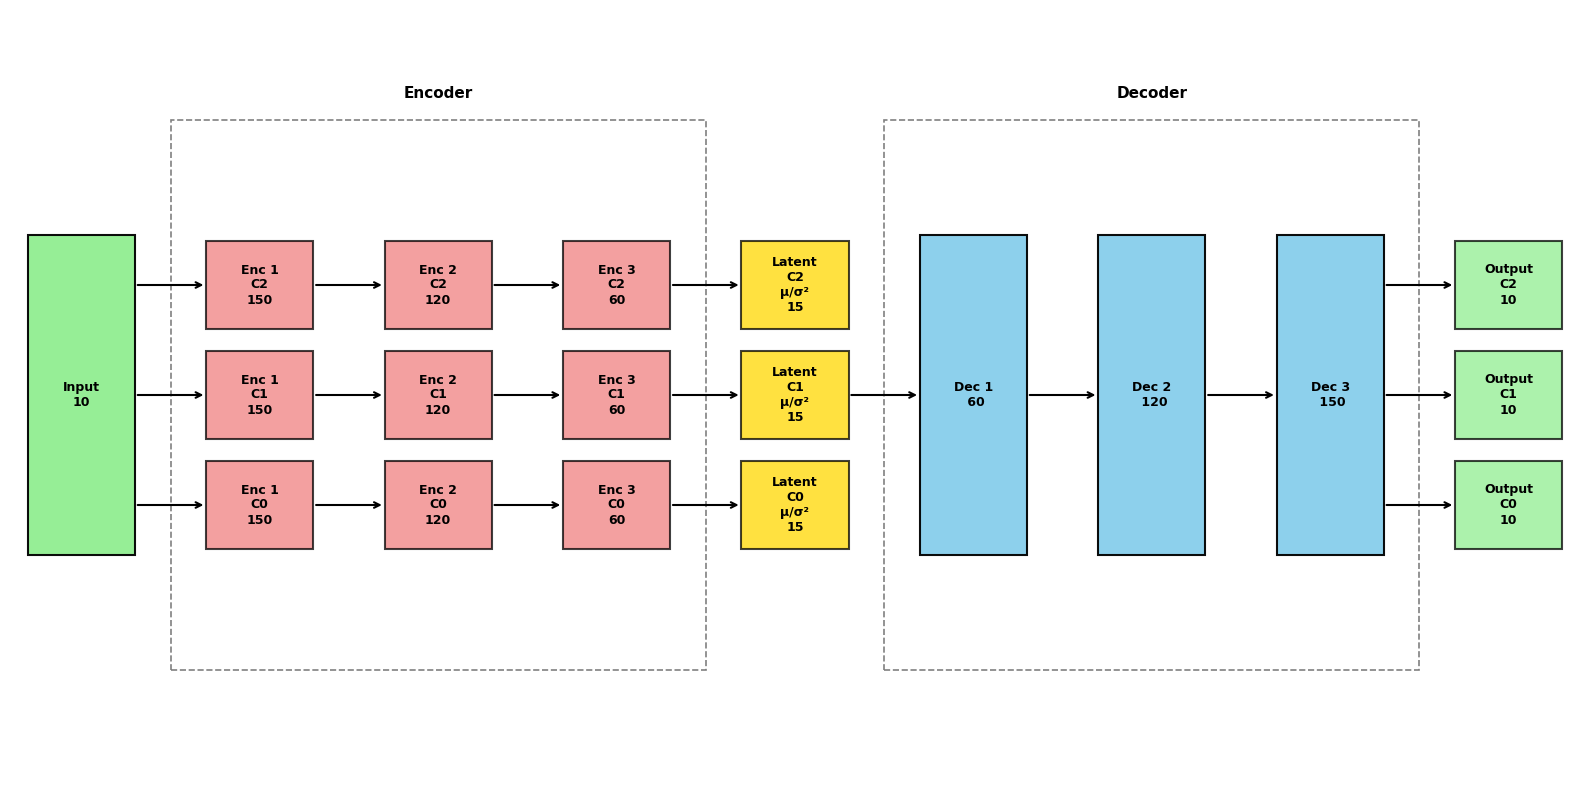

In [5]:
plot_vae_architecture(model = vae,
                        title = None, ## Set title of plot
                        ## Colors below are default
                        color_shared = "skyblue", 
                        color_unshared ="lightcoral",
                        color_latent = "gold", # xx fix
                        color_input = "lightgreen",
                        color_output = "lightgreen",
                        figsize=(16, 8),
                        return_fig = False)

## Using Binary Feature Mask with Autotune

To use a `binary_feature_mask` with `autotune()`, pass the use the `binary_feature_mask` parameter when initializing the `ClusterDataset` object. 

In [6]:
from ciss_vae.classes.cluster_dataset import ClusterDataset
from ciss_vae.training.autotune import autotune, SearchSpace
cd = ClusterDataset(
    X, cluster_labels = clusters, binary_feature_mask=binary_vector
)

ss = SearchSpace(
    num_hidden_layers = [1, 2],
    hidden_dims = [6, 16, 32],
    latent_dim=10,
    latent_shared=True,
    output_shared = True,
    lr = 0.01,
    decay_factor=0.999,
    num_epochs = 100,
    num_shared_encode = 1,
    num_shared_decode = 1,
    epochs_per_loop=100,
    reset_lr_refit=False

)
autotune(search_space = ss, train_dataset = cd, optuna_dashboard_db =  "sqlite:///optuna_study_test_binary.db", debug = True)

[Warning] CUDA requested but not available. Falling back to CPU.


[I 2025-10-21 15:35:53,188] Using an existing study with name 'vae_autotune' instead of creating a new one.
/home/nfs/vaithid1/CISS-VAE/CISS-VAE/src/ciss_vae/training/autotune.py:559: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(["Validation MSE"])


Starting Optuna optimization with 20 trials...


[I 2025-10-21 15:35:57,826] Trial 40 finished with value: {'Validation MSE': 218.12374877929688} and parameters: {'num_hidden_layers': 2, 'hidden_dim_0': 16, 'hidden_dim_1': 32, 'encoder_shared_placement': 'random', 'decoder_shared_placement': 'alternating'}. Best is trial 1 with value: 102.11430358886719.
[I 2025-10-21 15:36:00,334] Trial 41 finished with value: {'Validation MSE': 352.259521484375} and parameters: {'num_hidden_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 32, 'encoder_shared_placement': 'random', 'decoder_shared_placement': 'alternating'}. Best is trial 1 with value: 102.11430358886719.
[I 2025-10-21 15:36:03,794] Trial 42 finished with value: {'Validation MSE': 334.42010498046875} and parameters: {'num_hidden_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 32, 'encoder_shared_placement': 'random', 'decoder_shared_placement': 'alternating'}. Best is trial 1 with value: 102.11430358886719.
[I 2025-10-21 15:36:08,220] Trial 43 finished with value: {'Validation MSE': 2

Optimization complete. Best trial: 1 (MSE: 102.114304)
Training final model with best parameters...
Final model training complete.


(    feat1     feat2     feat3     feat4     feat5           bf1           bf2  \
 0    52.0  2.000000  6.000000  4.000000  2.000000  3.021081e-04  3.503911e-04   
 1    93.0  1.000000  7.000000  3.738120  2.000000  5.655538e-07  1.000000e+00   
 2    15.0  4.000000  5.879359  4.000000  2.000000  0.000000e+00  0.000000e+00   
 3    72.0  4.000000  3.000000  4.021034  1.000000  3.133329e-01  1.000000e+00   
 4    61.0  2.966509  1.000000  2.294644  1.000000  0.000000e+00  5.815911e-03   
 ..    ...       ...       ...       ...       ...           ...           ...   
 95   85.0  1.618145  2.151930  6.000000  2.000000  0.000000e+00  0.000000e+00   
 96   80.0  1.000000  1.739903  7.000000  2.000000  0.000000e+00  7.084425e-08   
 97   82.0  2.000000  4.000000  4.205121  1.000000  0.000000e+00  4.953528e-06   
 98   53.0  4.000000  3.000000  7.000000  7.000000  1.345421e-08  0.000000e+00   
 99   24.0  4.000000  1.000000  3.000000  6.277963  0.000000e+00  1.000000e+00   
 
          bf3 